# Determining Student Knowledge Status

Questions for TA:
1. Are we supposed to wrangle our test data like we do our training data? Or is this supposed to be in a recipe?
2. Is the wide table format we're currently using tidy? Or do we need to change it up?
    - can we use a long format for visualization and the wide for building the model?
3. Given our variables are normalized, do we need to add step_scale and step_center to our recipe?
4. We set the seed ONCE, correct?

### Introduction

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five normalized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

### Preliminary Exploratory Data Analysis

In [2]:
## Run this cell before continuing
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

The dataset is already split into training and testing data, so we do not have to perform an initial split to separate the data. Now, let's read in our training and testing data:

In [38]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "data/Data_User_Modeling_Dataset.xls")

knowledge_training <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 2) %>%
    select(STG:UNS)

knowledge_testing <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 3) %>%
    select(STG:UNS)

head(knowledge_training, n = 5)
head(knowledge_testing, n = 5)

New names:
* `` -> ...7
* `` -> ...8

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


Note that the first five variables are already normalized to be in the range [0, 1], where a higher number is associated with a higher degree of preparation or a higher exam performance. This will actually make things easier for us when training our classification model!

Additionaly, note that out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [39]:
knowledge_testing <- knowledge_testing %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

knowledge_training <- knowledge_training %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

head(knowledge_training, n = 5)
head(knowledge_testing, n = 5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


That's better. Let's continue tidying up the data! 

As we can see from the above dataframes, the labelling done on the test and training sets are different! In particular, the label representing a very low knowledge level varies. In the test dataset it's 'Very Low' and in the training dataset it's 'very_low'.

This may not be the only difference, so let's compare the labels present in both the test and training datasets.

In [40]:
knowledge_training %>%
    pull(SKL) %>%
    unique()

[1] "very_low" "High"     "Low"      "Middle"

In [41]:
knowledge_testing %>%
    pull(SKL) %>%
    unique()

[1] "Very Low" "Low"      "High"     "Middle"

As we can see, the only difference between the two sets of labels are for the very low category of knowlege. A few changes will fix this right up and make the data easier to work with:
- Firstly, we will remove the underscore in the label 'very_low' in the training dataset
- Secondly, we will transform all knowledge level (SKL) labels to lower case
- Then we'll transform the knowledge level (SKL) column to be a factor column (instead of the current character column)
- And, finally, we'll order the different levels to be in ascending order

In [42]:
# remove the underscore
knowledge_training <- knowledge_training %>%
    mutate(SKL = replace(knowledge_training$SKL, knowledge_training$SKL == "very_low", "very low"))

# change label to a factor
knowledge_training <- knowledge_training %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_training %>%
    pull(SKL) %>%
    levels()

[1] "very low" "high"     "low"      "middle"

The levels for the training set look good, let's just order them:

In [43]:
knowledge_training$SKL <- factor(knowledge_training$SKL, levels=c("very low", "low", "middle", "high"))
knowledge_training %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

Onto the testing dataset:

In [44]:
knowledge_testing <- knowledge_testing %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_testing %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "high"     "middle"

Again, let's order the levels:

In [45]:
knowledge_testing$SKL <- factor(knowledge_testing$SKL, levels=c("very low", "low", "middle", "high"))
knowledge_testing %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

Perfect! Now that our class labels are consistent across datasets, let's have a final look:

In [46]:
head(knowledge_training, n = 4)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very low
0.08,0.08,0.10,0.24,0.90,high
0.06,0.06,0.05,0.25,0.33,low
0.10,0.10,0.15,0.65,0.30,middle


In [47]:
head(knowledge_testing, n = 4)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,very low
0.05,0.05,0.55,0.60,0.14,low
0.08,0.18,0.63,0.60,0.85,high
0.20,0.20,0.68,0.67,0.85,high


There, that's more like it. Our data is now tidy, that is: 
- each row is a single observation (a student)
- each column is a single variable, and 
- each cell contains a single value (normalized degree of study or exam performance)

Now that we have properly wrangled the data, we can proceed to do the following:
1. lock our test data in an imaginary box, only to be opened when evaluating the model we will build
2. summarize our training data 
3. explore and visualize patterns/trends within the data

After which, we will build our model.

First things first, let's summarize the data to gain some more insight. To do this, we create a table that will do the following for each knowledge level:
1. report the number of observations
2. report the predictor means, and 
3. report the number of rows that have missing data 

In [48]:
summary_table <- knowledge_training %>%
    group_by(SKL) %>%
    summarize(class_count = n(),
              mean_stg = mean(STG),
              mean_rng = mean(RNG),
              mean_str = mean(STR),
              mean_epr = mean(EPR),
              mean_epg = mean(EPG),
              missing_rows = sum(is.na(SKL))) %>%
    arrange(mean_epg)
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



SKL,class_count,mean_stg,mean_rng,mean_str,mean_epr,mean_epg,missing_rows
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
very low,24,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333,0
low,83,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651,0
middle,88,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636,0
high,63,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968,0


Wonderful! It appears that our target variable contains no missing values.

Additionally, if you look at the different predictor means in relation to the student's knowledge level, we generally see that as the predictor mean increases, the student's knowledge level increases as well (with the exception of `EPR` which is a student's exam performance for related objects)! This gives us some intuition that we may see a positive relationship between these predictors and a student's knowledge level.

Let's visualize the predictor - student knowlege level relationships to get a better understanding.

LOOK HERE: https://www.datacamp.com/community/tutorials/facets-ggplot-r

**CLARIFY**: maybe dataset isn't tidy...

In [ ]:
# do visualization

As we can see, there is a positive relationship between a student's knowlegde level `SKL` and the following:
- the degree of study time for goal object materials, `STG`
- the degree of repetition number for goal object materials, `RNG`
- the degree of study time for related object materials, `STR` and
- the exam performance for goal object materials, `EPG`

This will be ...

Fantastic, we can now begin building our model!

Let's begin by selecting the type of model we will be building. Seeing as we aim to classify a student's knowledge level into one of four categories, our problem is one of classification by nature. While there are numerous classification algorithms available, we will use the K-Nearest Neighbors algorithm.

< Description here of the knn algorithm >

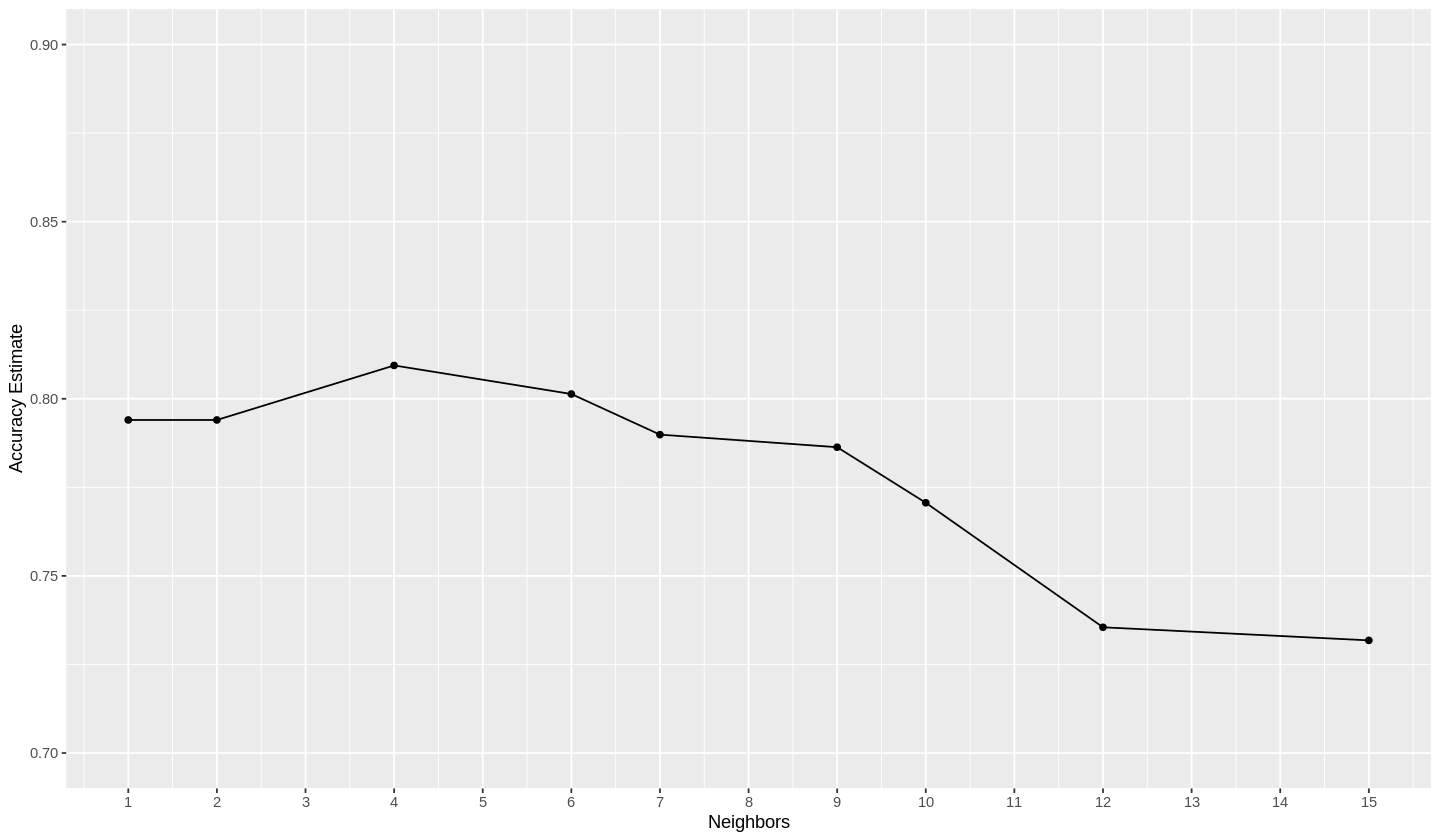

In [49]:
# these would go in the 'library' cell
options(repr.plot.width = 12, repr.plot.height = 7)
set.seed(18)

# Create the knn recipe 
knn_recipe <- recipe(SKL ~ STG + RNG + STR + EPR + EPG, data = knowledge_training)

# Create the knn spec to find the best k- value 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create the v-fold 
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = SKL)

# Create the workflow and collect statistics
knn_results <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = knowledge_vfold, grid = 10) %>%
    collect_metrics()

# Calculate and plot accuracy estimates
accuracies <- knn_results %>%
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +
    scale_y_continuous(limits = c(0.7, 0.9))
accuracy_versus_k

Based on the plot above, we see that $k = 4$ would be a good choice for our $k$ since this gives us the highest accuracy estimate. Additionally, choosing values close to $k = 4$ would not significantly decrease our accuracy.

Now that we have our best choice of $k$, let's use it to create our final model. 

In [50]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = knowledge_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~4, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2364341
Best kernel: rectangular
Best k: 4

Now that we have our final model created, let's evaluate it on our test dataset and find out how accurate it really is!

In [51]:
knowledge_predictions <- knn_fit %>%
    predict(knowledge_testing) %>%
    bind_cols(knowledge_testing)

head(knowledge_predictions, n = 5)

.pred_class,STG,RNG,STR,EPR,EPG,SKL
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
very low,0.00,0.10,0.50,0.26,0.05,very low
low,0.05,0.05,0.55,0.60,0.14,low
high,0.08,0.18,0.63,0.60,0.85,high
high,0.20,0.20,0.68,0.67,0.85,high
high,0.22,0.22,0.90,0.30,0.90,high


Time to evaluate the accuracy:

In [53]:
knowledge_metrics <- knowledge_predictions %>%
    metrics(truth = SKL, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

knowledge_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8275862


As you can see, the accuracy of our model - as evaluated on the testing dataset - is around $82$%. Is this good? Let's have a look at a confusion matrix before we answer this:

In [57]:
knowledge_predictions %>%
    conf_mat(truth = SKL, estimate = .pred_class)

          Truth
Prediction very low low middle high
  very low       15   2      0    0
  low            11  42      6    0
  middle          0   2     27    3
  high            0   0      1   36

notes:
- very low is confused for low many times; potentially due to the undersampling of very low (only 23 observations while the others have around 80)
- middle confused for low 

not dealing with Malignant/Benign case so 82% is pretty good imo... thoughts?

### Discussion